In [1]:
import torch
import torchvision
import numpy
import random
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm 

import os
from pathlib import Path
from typing import List, Tuple

In [2]:
os.chdir(r'C:\python\try_to_nn')

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def count_params(model: torch.nn.Module):
    params_generator = model.parameters()
    return sum([p.numel() for p in params_generator])

#### Датакласс

In [5]:
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, split, root="./data/tiny-imagenet-200", transform=None, num_classes=10):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform 
        self.classes = None

        wnids_path = self.root + "/wnids.txt"
        with open(wnids_path, mode='r', encoding='utf-8') as file:
            file = file.readlines()
            if num_classes:
                file = file[:num_classes]
            self.classes = {cls.strip(): i for i, cls in enumerate(file)}

        match split:
            case 'train':
                self._select_train_frames()
            case 'val':
                self._select_val_frames()
            case 'test':
                self._select_test_frames()
                
    def _select_train_frames(self, train_root: str = "train") -> List[Tuple[str, int]]:
        train_root = self.root + "/" + train_root
        samples = []
        for cls_name, cls_label in self.classes.items():
            cls_images_root = train_root + f'/{cls_name}' + '/images'
            cls_images_paths = os.listdir(cls_images_root)
            cls_images_paths = list(map(lambda x: cls_images_root + '/' + str(x), cls_images_paths))
            labels = [cls_label] * len(cls_images_paths)
            samples.extend(list(zip(cls_images_paths, labels)))
        self.samples = samples
    
    def _select_val_frames(self, val_root: str = "val", 
                           annotations_path: str = "val/val_annotations.txt") -> List[Tuple[str, int]]:
        val_root = self.root + "/" + val_root
        annotations_path = self.root + "/" + annotations_path
        images_path = val_root + '/images/'
        with open(annotations_path, mode='r', encoding='utf-8') as file:
            lines = file.readlines()
        self.samples = []
        for line in lines:
            parts = line.strip().split('\t')
            
            img_name = parts[0]
            cls_name = parts[1]
            
            if cls_name in self.classes:
                full_path = os.path.join(images_path, img_name)
                label = self.classes[cls_name]
                self.samples.append((full_path, label))       
            
    def _select_test_frames(self, test_root: str = "test/images/") -> List[Tuple[str, int]]:
        test_root = self.root + "/" + test_root
        images = os.listdir(test_root)
        images = list(map(lambda x: test_root + str(x), images))
        labels = [-1]*len(images)
        self.samples = list(zip(images, labels))

    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, img_path: str):
        with open(img_path, mode='rb') as file:
            image = Image.open(file)
            return image.convert(mode='RGB')
    
    def __getitem__(self, index):
        image_path, image_label = self.samples[index]

        image = self._load_image(image_path)
        if self.transform:
            image = self.transform(image)

        return image, image_label
        




#### Residual Block

In [34]:
import torch.nn.functional as F
from torch import nn 

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        x_in = x
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))
        out += self.downsample(x_in)
        out = self.relu(out)

        return out




#### ResNet18

Архитектура немного изменена для того, чтобы уложиться в ограничение по параметрам (<5 млн)

In [35]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
        # self.basic_block4 = nn.Sequential(
        #     ResidualBlock(
        #     in_channels=256,
        #     out_channels=256,
        #     stride=2
        #     ),
        #     ResidualBlock(
        #     in_channels=256,
        #     out_channels=256,
        #     stride=1
        #     )
        # )
        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)
        # x = self.basic_block4(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



In [9]:
model = ResNet18()

In [10]:
count_params(model)

2777674

#### Обучаем первую архитектуру

In [37]:
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset(split='train', root='./data/tiny-imagenet-200', transform=train_transform)
val_dataset = TinyImageNetDataset(split='val', root='./data/tiny-imagenet-200', transform=val_transform)
test_dataset = TinyImageNetDataset(split='test', root='./data/tiny-imagenet-200', transform=val_transform)

In [38]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [39]:
device = device
model = ResNet18()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

In [66]:
# from torch.optim.lr_scheduler import StepLR
import copy

def train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=5):
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    # scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in tqdm(range(num_epoch), desc="Training"):
        model.train()
        
        running_train_loss = 0.0
        running_train_acc = 0.0
        
        for i, train_batch in enumerate(train_dataloader):
            x_train_batch, y_train_batch = train_batch[0].to(device), train_batch[1].to(device)
            
            optimizer.zero_grad()
            logits = model(x_train_batch)
            loss = loss_func(logits, y_train_batch)
            
            loss.backward()
            optimizer.step()
            
            predicted_classes = torch.argmax(logits, dim=1)
            acc = (predicted_classes == y_train_batch).float().mean().item()
            
            running_train_loss += loss.item()
            running_train_acc += acc
            
        # scheduler.step()
        epoch_avg_train_loss = running_train_loss / len(train_dataloader)
        epoch_avg_train_acc = running_train_acc / len(train_dataloader)
        
        train_loss_history.append(epoch_avg_train_loss)
        train_accuracy_history.append(epoch_avg_train_acc)

        with torch.no_grad():
            model.eval()
            running_val_loss = 0.0
            running_val_acc = 0.0
            
            for j, val_batch in enumerate(val_dataloader):
                x_val_batch, y_val_batch = val_batch[0].to(device), val_batch[1].to(device)
            
                val_logits = model(x_val_batch)
                val_loss = loss_func(val_logits, y_val_batch)

                predicted_classes = torch.argmax(val_logits, dim=1)
                val_acc = (predicted_classes == y_val_batch).float().mean().item()

                running_val_loss += val_loss.item()
                running_val_acc += val_acc
        
        epoch_avg_val_loss = running_val_loss / len(val_dataloader)
        epoch_avg_val_acc = running_val_acc / len(val_dataloader)

        if epoch_avg_val_acc > best_acc:
            best_acc = epoch_avg_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        val_loss_history.append(epoch_avg_val_loss)
        val_accuracy_history.append(epoch_avg_val_acc)
        
    model.load_state_dict(best_model_wts)
    return {
        'train': {
            'loss': train_loss_history,
            'accuracy': train_accuracy_history
        },
        'val': {
            'loss': val_loss_history,
            'accuracy': val_accuracy_history
        }
    }

In [41]:
metrics = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

Training: 100%|██████████| 35/35 [07:50<00:00, 13.44s/it]


In [96]:
model_resnet18 = ResNet18()
params_resnet18 = count_params(model_resnet18)
resnet18_accuracy = max(metrics['val']['accuracy'])
resnet18_loss = min(metrics['val']['loss'])

In [17]:
def plot_training_results(history):

    train_loss = history['train']['loss']
    val_loss = history['val']['loss']
    train_acc = history['train']['accuracy']
    val_acc = history['val']['accuracy']
    

    if len(train_loss) > 0 and isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.detach().cpu().item() for x in train_loss]
        val_loss = [x.detach().cpu().item() for x in val_loss]
        
    if len(train_acc) > 0 and isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.detach().cpu().item() for x in train_acc]
        val_acc = [x.detach().cpu().item() for x in val_acc]

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-o', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-o', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def print_model_info(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("\nModel Architecture:")
    print(model)

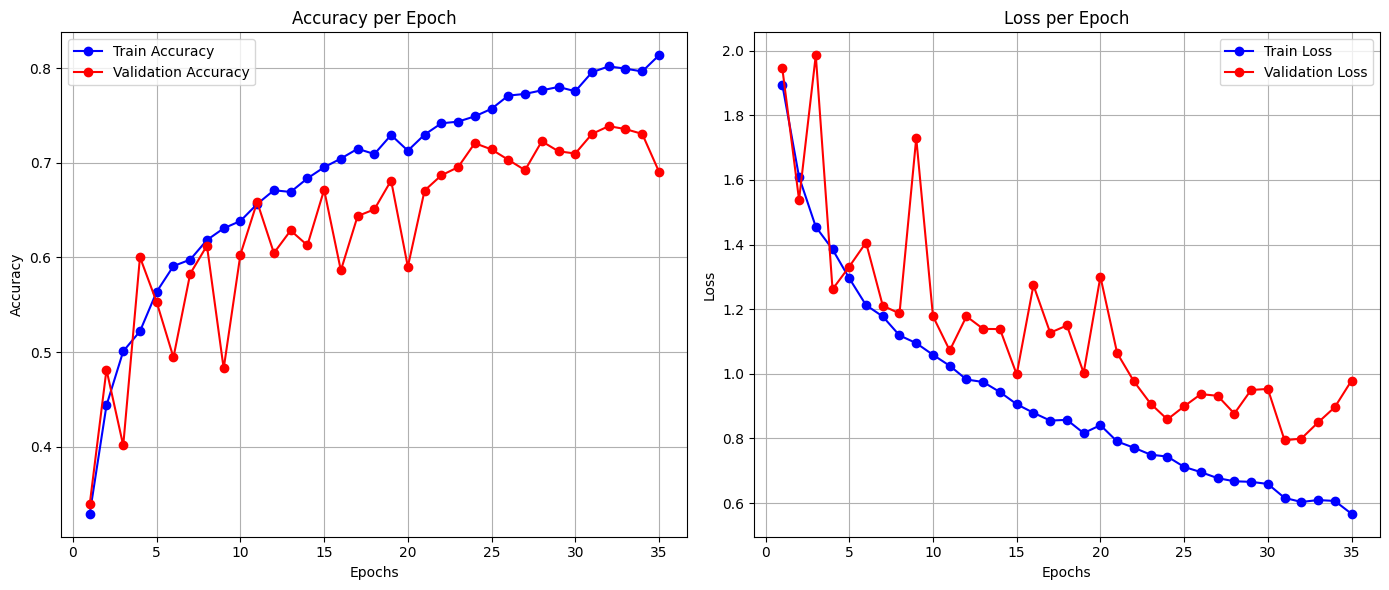

In [42]:
plot_training_results(metrics)

### Второй вариант модели (32 → 64 → 128 → 256 каналов)

In [43]:
class ResNet18_4layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=32,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=32,
            out_channels=32,
            stride=1
            ),
            ResidualBlock(
            in_channels=32,
            out_channels=32,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=32,
            out_channels=64,
            stride=2
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block4 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)
        x = self.basic_block4(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



In [44]:
device = device
model = ResNet18_4layers()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

In [45]:
metrics_4layers = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

Training: 100%|██████████| 35/35 [07:22<00:00, 12.64s/it]


In [94]:
model_resnet18_4l = ResNet18_4layers()
params_resnet18_4l = count_params(model_resnet18_4l)
resnet18_4l_accuracy = max(metrics_4layers['val']['accuracy'])
resnet18_4l_loss = min(metrics_4layers['val']['loss'])

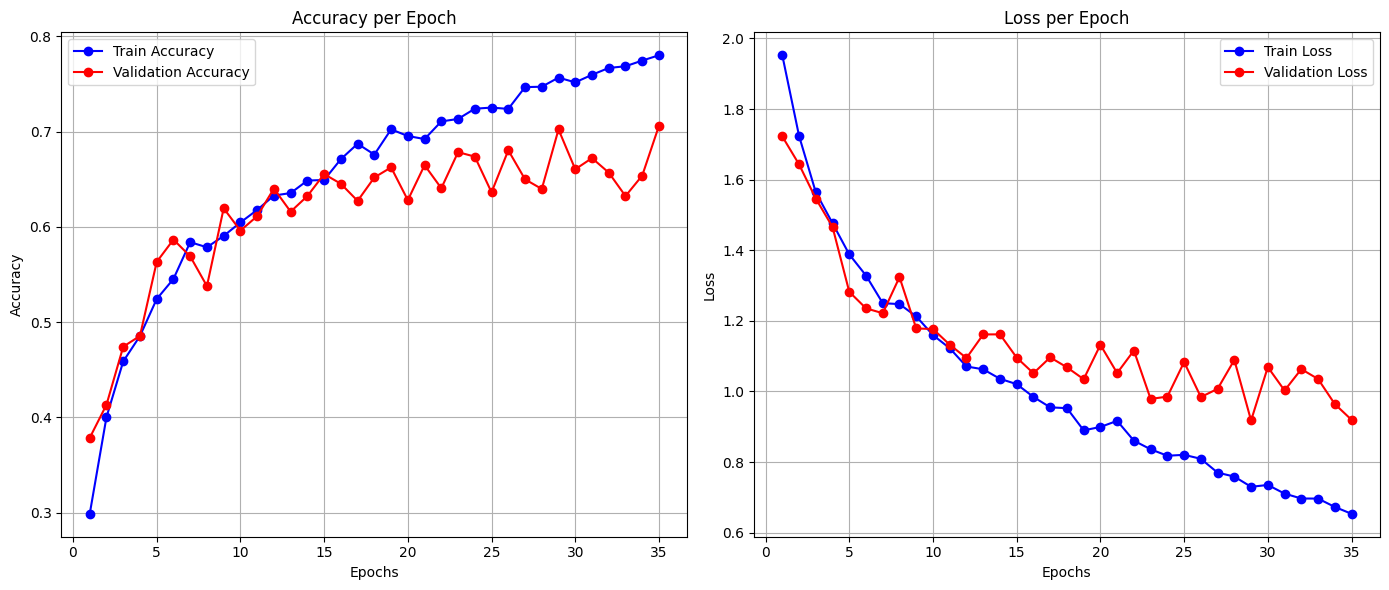

In [46]:
plot_training_results(metrics_4layers)

### Третий вариант модели: 64 → 128 → 256 каналов (без 4-го слоя)

In [47]:
class ResNet18_3layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
        # self.basic_block4 = nn.Sequential(
        #     ResidualBlock(
        #     in_channels=128,
        #     out_channels=256,
        #     stride=2
        #     ),
        #     ResidualBlock(
        #     in_channels=256,
        #     out_channels=256,
        #     stride=1
        #     )
        # )

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)
        # x = self.basic_block4(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



In [48]:
device = device
model = ResNet18_3layers()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

In [49]:
metrics_3layers = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

Training: 100%|██████████| 35/35 [07:48<00:00, 13.38s/it]


In [93]:
model_resnet18_3l = ResNet18_3layers()
params_resnet18_3l = count_params(model_resnet18_3l)
resnet18_3l_accuracy = max(metrics_3layers['val']['accuracy'])
resnet18_3l_loss = min(metrics_3layers['val']['loss'])

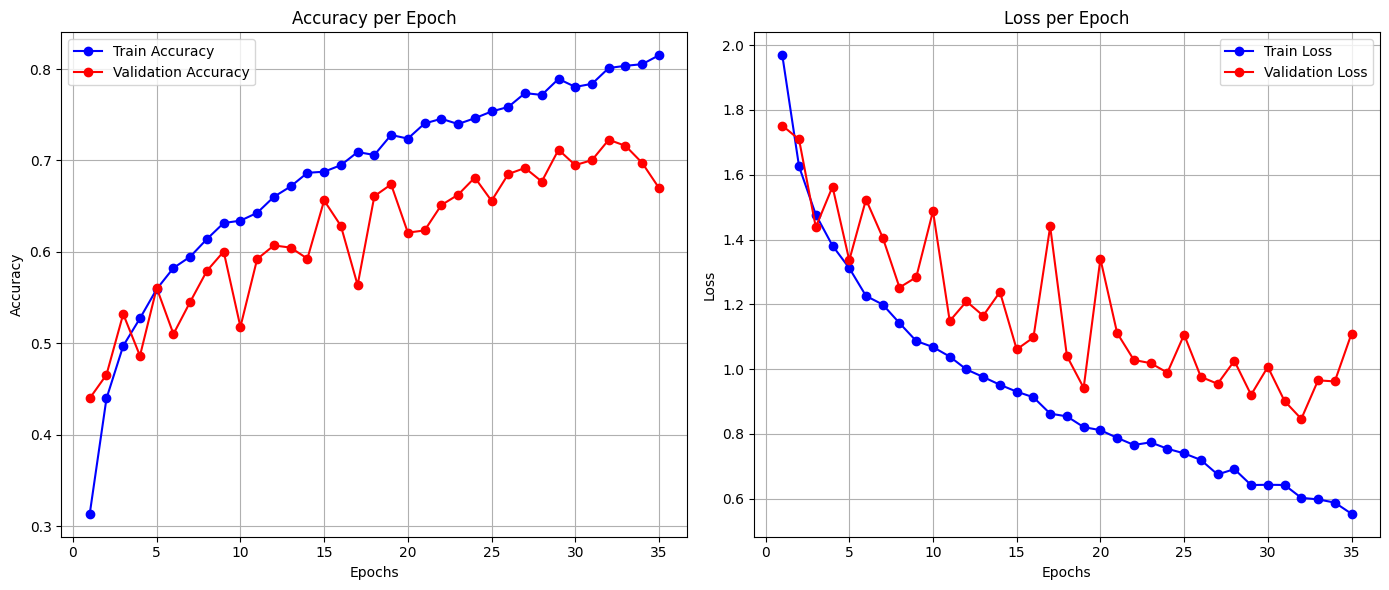

In [50]:
plot_training_results(metrics_3layers)

### Вывод: лучше всех себя показала конфигурация №1

Далее посмотрим, как количество residual-блоков влияет на качество модели

##### ResidualBlock x1

In [51]:
class ResNet18_rbx1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=2
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=1
            )
        )

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [07:07<00:00, 12.21s/it]


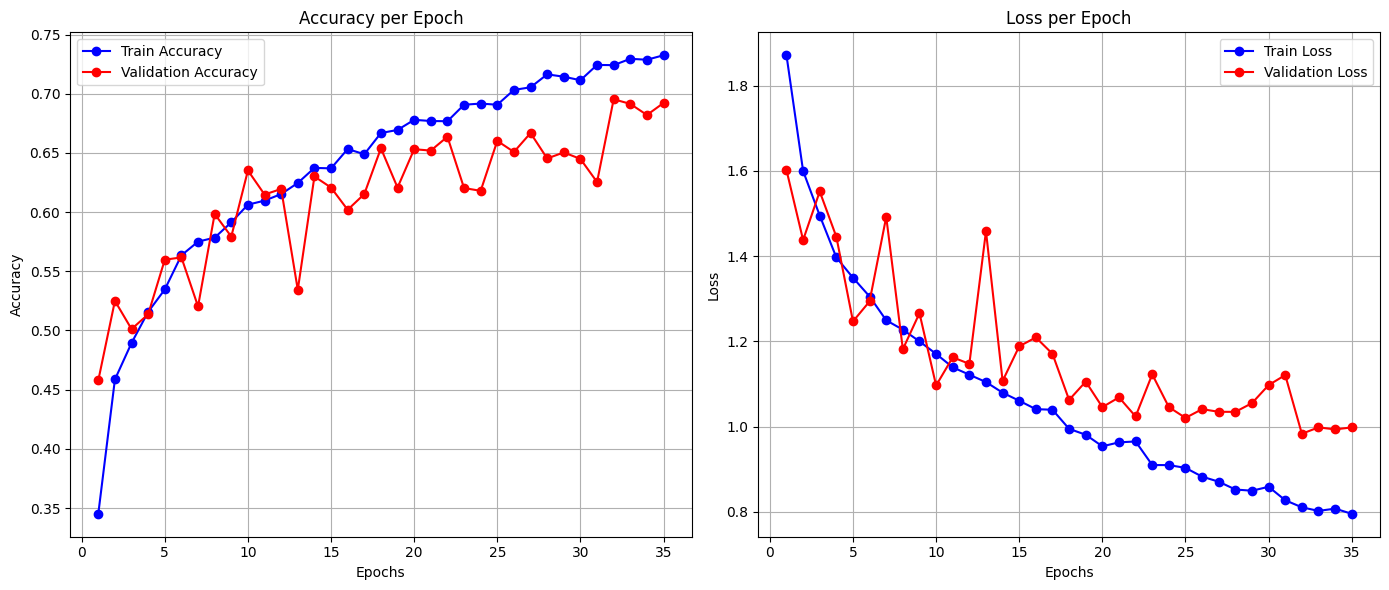

In [52]:
device = device
model = ResNet18_rbx1()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx1 = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx1)

In [97]:
model_resnet18_rbx1 = ResNet18_rbx1()
params_resnet18_rbx1 = count_params(model_resnet18_rbx1)
resnet18_rbx1_accuracy = max(metrics_rbx1['val']['accuracy'])
resnet18_rbx1_loss = min(metrics_rbx1['val']['loss'])

##### ResidualBlock x2

In [53]:
class ResNet18_rbx2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
     

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [07:52<00:00, 13.49s/it]


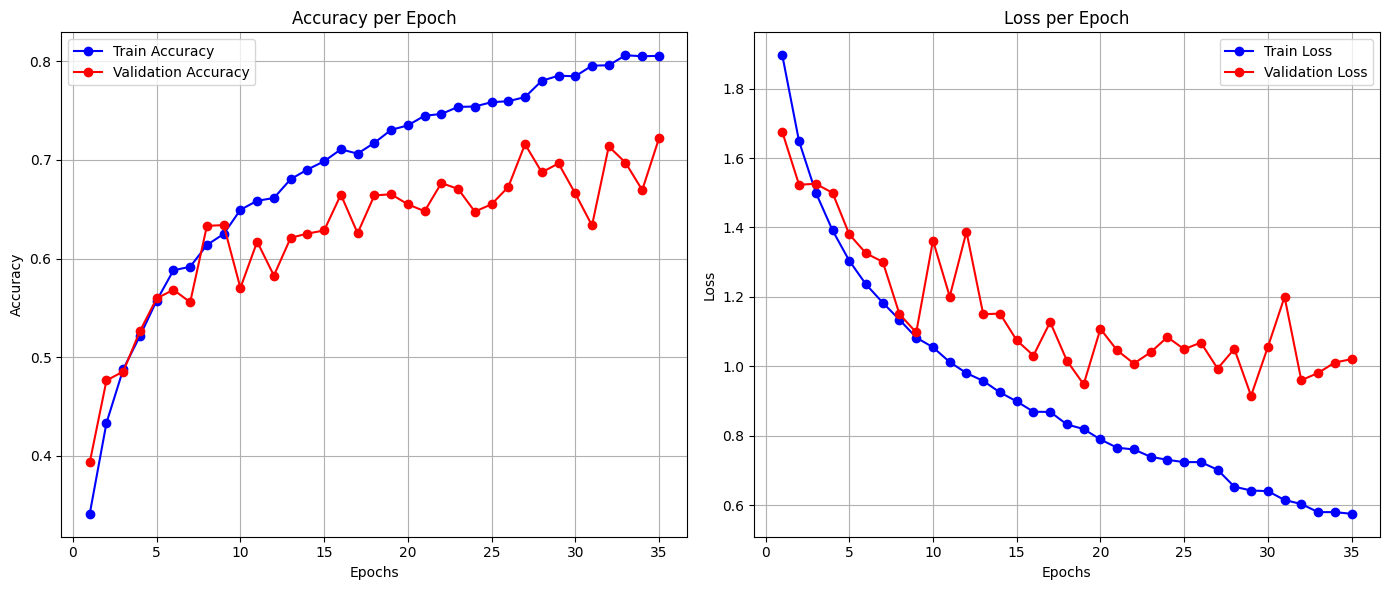

In [54]:
device = device
model = ResNet18_rbx2()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx2 = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx2)

In [98]:
model_resnet18_rbx2 = ResNet18_rbx2()
params_resnet18_rbx2 = count_params(model_resnet18_rbx2)
resnet18_rbx2_accuracy = max(metrics_rbx2['val']['accuracy'])
resnet18_rbx2_loss = min(metrics_rbx2['val']['loss'])

##### ResidualBlock x3

In [55]:
class ResNet18_rbx3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            ),
            ResidualBlock(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            ),
            ResidualBlock(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
     

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [09:02<00:00, 15.51s/it]


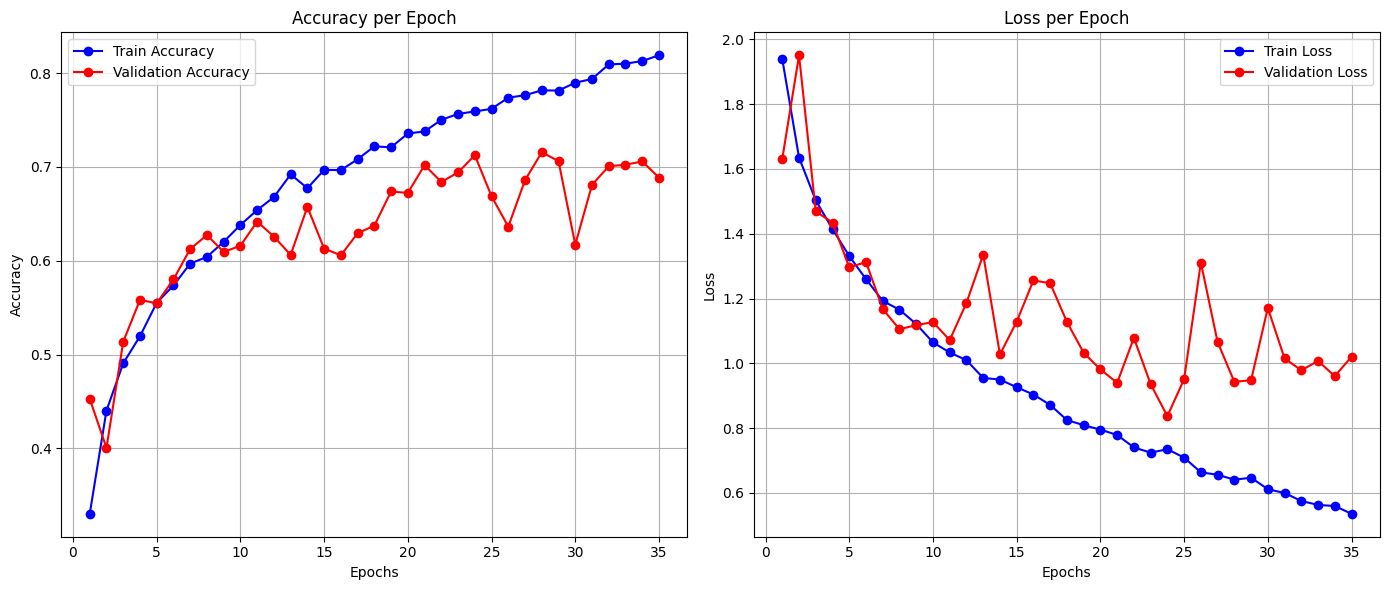

In [67]:
device = device
model = ResNet18_rbx3()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx3 = train_resnet(model, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx3)

In [99]:
model_resnet18_rbx3 = ResNet18_rbx3()
params_resnet18_rbx3 = count_params(model_resnet18_rbx3)
resnet18_rbx3_accuracy = max(metrics_rbx3['val']['accuracy'])
resnet18_rbx3_loss = min(metrics_rbx3['val']['loss'])

### Эксперименты с функциями активации

#### ReLU (baseline)

#### LeakyReLU

In [57]:
class ResidualBlock_LReLU(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.Lrelu = nn.LeakyReLU(inplace=True)

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        x_in = x
        out = self.Lrelu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))
        out += self.downsample(x_in)
        out = self.Lrelu(out)

        return out




In [58]:
class ResNet18_rbx3_LReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.Lrelu = nn.LeakyReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock_LReLU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_LReLU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_LReLU(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock_LReLU(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock_LReLU(
            in_channels=128,
            out_channels=128,
            stride=1
            ),
            ResidualBlock_LReLU(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock_LReLU(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock_LReLU(
            in_channels=256,
            out_channels=256,
            stride=1
            ),
            ResidualBlock_LReLU(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
     

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.Lrelu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [09:12<00:00, 15.80s/it]


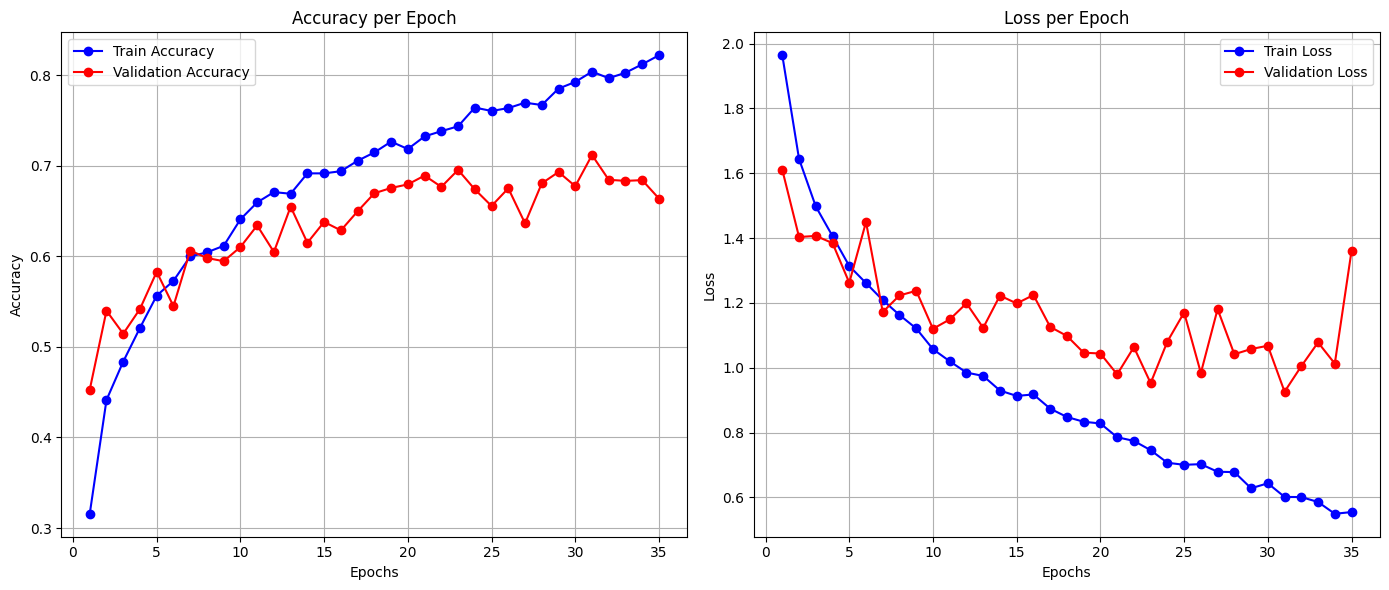

In [ ]:
device = device
model_rn18_rb3_lrelu = ResNet18_rbx3_LReLU()
optimizer = torch.optim.Adam(params=model_rn18_rb3_lrelu.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx3_LReLU = train_resnet(model_rn18_rb3_lrelu, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx3_LReLU)

In [101]:
model_resnet18_rbx3_lrelu = ResNet18_rbx3_LReLU()
params_resnet18_rbx3_lrelu = count_params(model_resnet18_rbx3_lrelu)
resnet18_rbx3_lrelu_accuracy = max(metrics_rbx3_LReLU['val']['accuracy'])
resnet18_rbx3_lrelu_loss = min(metrics_rbx3_LReLU['val']['loss'])

#### ELU

In [60]:
class ResidualBlock_ELU(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.elu = nn.ELU(inplace=True)

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        x_in = x
        out = self.elu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))
        out += self.downsample(x_in)
        out = self.elu(out)

        return out




In [61]:
class ResNet18_rbx3_ELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.elu = nn.ELU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock_ELU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_ELU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_ELU(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock_ELU(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock_ELU(
            in_channels=128,
            out_channels=128,
            stride=1
            ),
            ResidualBlock_ELU(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock_ELU(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock_ELU(
            in_channels=256,
            out_channels=256,
            stride=1
            ),
            ResidualBlock_ELU(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
     

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.elu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [09:18<00:00, 15.96s/it]


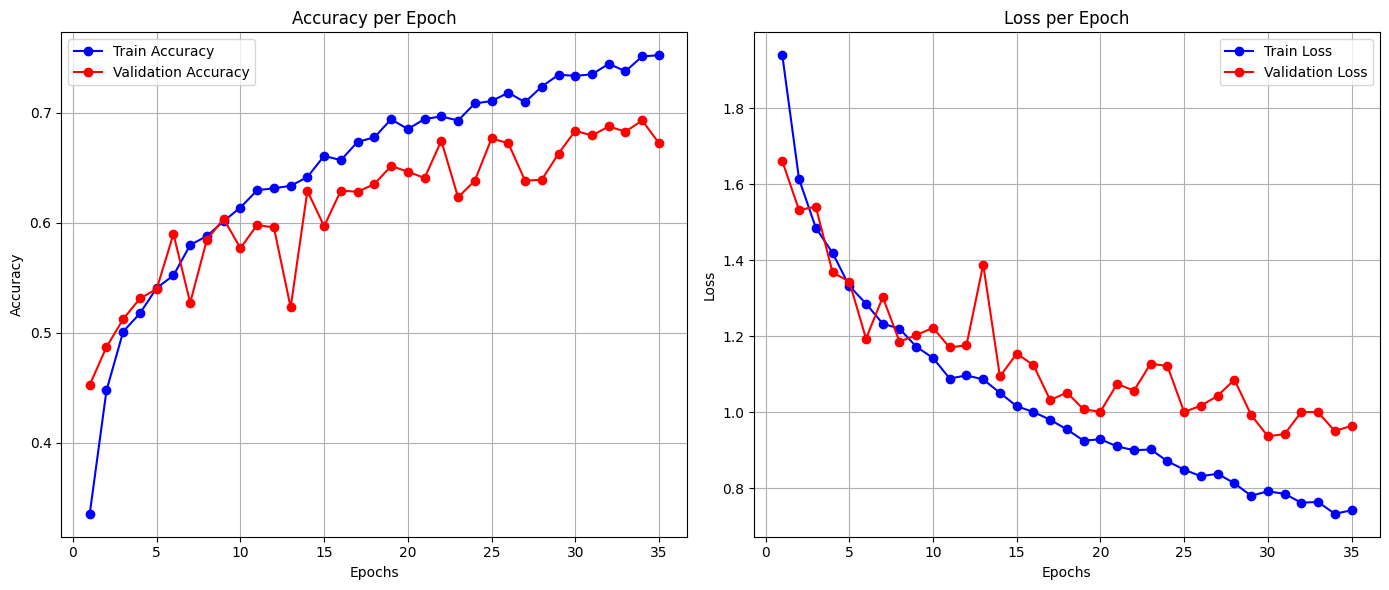

In [71]:
device = device
model_rn18_rb3_elu = ResNet18_rbx3_ELU()
optimizer = torch.optim.Adam(params=model_rn18_rb3_elu.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx3_elu = train_resnet(model_rn18_rb3_elu, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx3_elu)

In [102]:
model_resnet18_rbx3_elu = ResNet18_rbx3_ELU()
params_resnet18_rbx3_elu = count_params(model_resnet18_rbx3_elu)
resnet18_rbx3_elu_accuracy = max(metrics_rbx3_elu['val']['accuracy'])
resnet18_rbx3_elu_loss = min(metrics_rbx3_elu['val']['loss'])

#### GELU

In [63]:
class ResidualBlock_GELU(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.gelu = nn.GELU()

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        x_in = x
        out = self.gelu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))
        out += self.downsample(x_in)
        out = self.gelu(out)

        return out




In [64]:
class ResNet18_rbx3_GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.gelu = nn.GELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.basic_block1 = nn.Sequential(
            ResidualBlock_GELU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_GELU(
            in_channels=64,
            out_channels=64,
            stride=1
            ),
            ResidualBlock_GELU(
            in_channels=64,
            out_channels=64,
            stride=1
            )
        )
        self.basic_block2 = nn.Sequential(
            ResidualBlock_GELU(
            in_channels=64,
            out_channels=128,
            stride=2
            ),
            ResidualBlock_GELU(
            in_channels=128,
            out_channels=128,
            stride=1
            ),
            ResidualBlock_GELU(
            in_channels=128,
            out_channels=128,
            stride=1
            )
        )
        self.basic_block3 = nn.Sequential(
            ResidualBlock_GELU(
            in_channels=128,
            out_channels=256,
            stride=2
            ),
            ResidualBlock_GELU(
            in_channels=256,
            out_channels=256,
            stride=1
            ),
            ResidualBlock_GELU(
            in_channels=256,
            out_channels=256,
            stride=1
            )
        )
     

        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.maxpool1(self.gelu(self.bn1(self.conv1(x))))

        x = self.basic_block1(x)
        x = self.basic_block2(x)
        x = self.basic_block3(x)

        x = self.adapt_pool(x)

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.linear1(x)

        return x



Training: 100%|██████████| 35/35 [08:55<00:00, 15.29s/it]


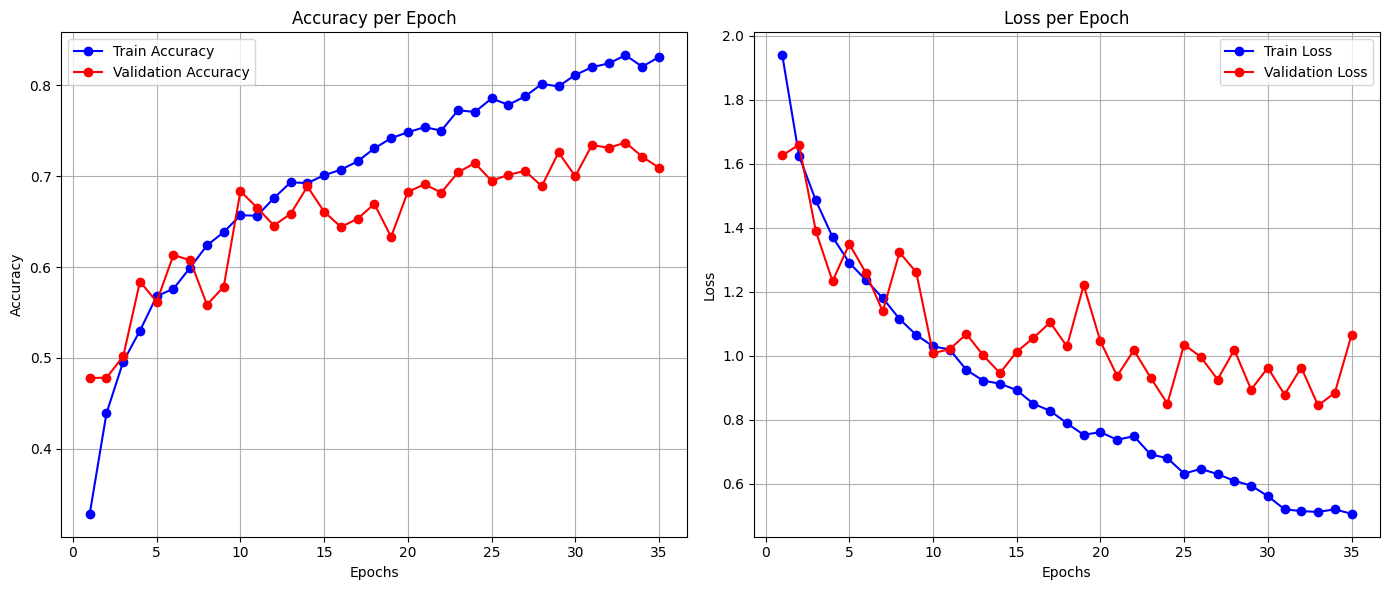

In [122]:
device = device
model_rn18_rb3_gelu = ResNet18_rbx3_GELU()
optimizer = torch.optim.Adam(params=model_rn18_rb3_gelu.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx3_gelu = train_resnet(model_rn18_rb3_gelu, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=35)

plot_training_results(metrics_rbx3_gelu)

In [123]:
model_resnet18_rbx3_gelu = ResNet18_rbx3_GELU()
params_resnet18_rbx3_gelu = count_params(model_resnet18_rbx3_gelu)
resnet18_rbx3_gelu_accuracy = max(metrics_rbx3_gelu['val']['accuracy'])
resnet18_rbx3_gelu_loss = min(metrics_rbx3_gelu['val']['loss'])

#### Модель с GELU является наиболее хорошей при данном количестве эпох, так как имеет высший скор по валидационной выборке, обучается стабильно и не показывает признаки деградации обучения к концу.

Training: 100%|██████████| 45/45 [11:22<00:00, 15.17s/it]


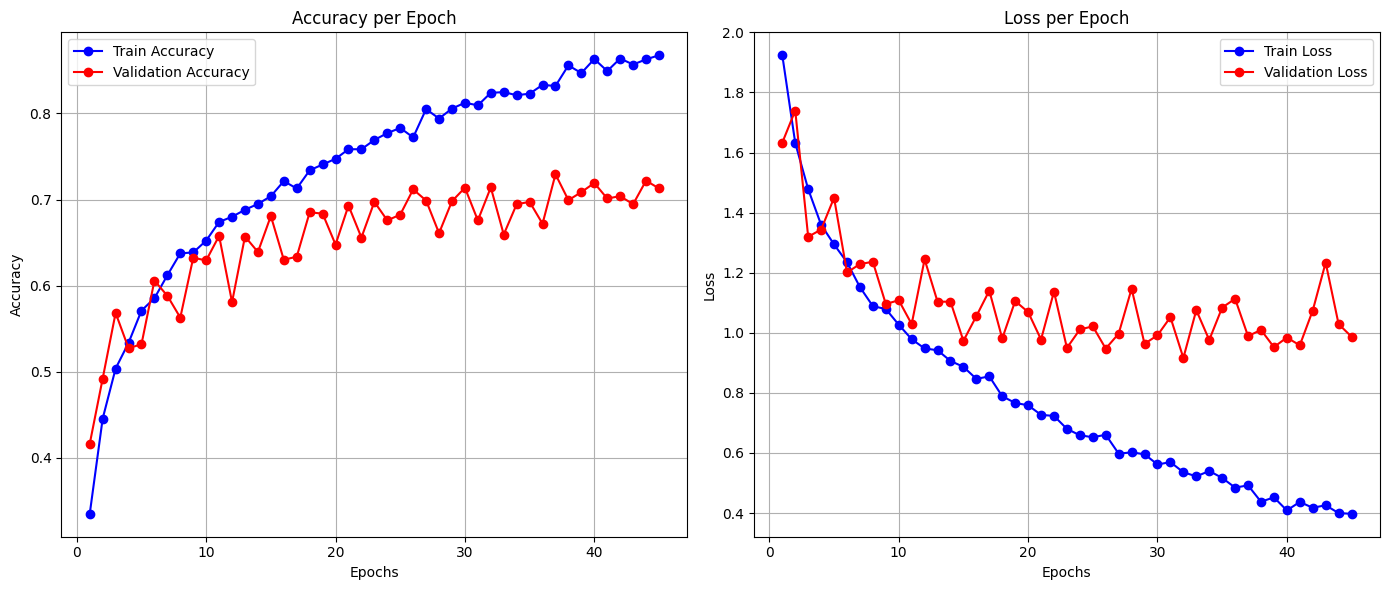

In [124]:
device = device
model_rn18_rb3_gelu_final = ResNet18_rbx3_GELU()
optimizer = torch.optim.Adam(params=model_rn18_rb3_gelu_final.parameters(), lr=0.0001, weight_decay=3e-4)
loss_func = torch.nn.CrossEntropyLoss()

metrics_rbx3_gelu_f = train_resnet(model_rn18_rb3_gelu_final, optimizer, loss_func, train_dataloader, val_dataloader, num_epoch=45)

plot_training_results(metrics_rbx3_gelu_f)

In [125]:
model_rn18_rb3_gelu_f = ResNet18_rbx3_GELU()
params_resnet18_rbx3_gelu_f = count_params(model_resnet18_rbx3_gelu)
resnet18_rbx3_gelu_f_accuracy = max(metrics_rbx3_gelu_f['val']['accuracy'])
resnet18_rbx3_gelu_f_loss = min(metrics_rbx3_gelu_f['val']['loss'])

In [119]:
max(metrics_rbx3_gelu['train']['accuracy'])

0.8837579617834395

Сохраняем модель

In [ ]:
torch.save(model_rn18_rb3_gelu_final.state_dict(), 'resnet18_rbx3_gelu.pth')

Тестируем модель

In [ ]:
loaded_model = ResNet18_rbx3_GELU() 
loaded_model.load_state_dict(torch.load('resnet18_rbx3_gelu.pth'))
loaded_model.eval()


<All keys matched successfully>

Тест модели невозможен, так как данные для теста не аннотированы, нельзя отобрать 10 нужных классов из всех фотографий и сопоставить их с предсказаниями модели

#### Итоговая таблица

In [104]:
model_resnet18 = ResNet18()
params_resnet18 = count_params(model_resnet18)
resnet18_accuracy = max(metrics['val']['accuracy'])
resnet18_loss = min(metrics['val']['loss'])

In [105]:
model_resnet18_4l = ResNet18_4layers()
params_resnet18_4l = count_params(model_resnet18_4l)
resnet18_4l_accuracy = max(metrics_4layers['val']['accuracy'])
resnet18_4l_loss = min(metrics_4layers['val']['loss'])

In [106]:
model_resnet18_3l = ResNet18_3layers()
params_resnet18_3l = count_params(model_resnet18_3l)
resnet18_3l_accuracy = max(metrics_3layers['val']['accuracy'])
resnet18_3l_loss = min(metrics_3layers['val']['loss'])

In [107]:
model_resnet18_rbx1 = ResNet18_rbx1()
params_resnet18_rbx1 = count_params(model_resnet18_rbx1)
resnet18_rbx1_accuracy = max(metrics_rbx1['val']['accuracy'])
resnet18_rbx1_loss = min(metrics_rbx1['val']['loss'])

In [108]:
model_resnet18_rbx2 = ResNet18_rbx2()
params_resnet18_rbx2 = count_params(model_resnet18_rbx2)
resnet18_rbx2_accuracy = max(metrics_rbx2['val']['accuracy'])
resnet18_rbx2_loss = min(metrics_rbx2['val']['loss'])

In [109]:
model_resnet18_rbx3 = ResNet18_rbx3()
params_resnet18_rbx3 = count_params(model_resnet18_rbx3)
resnet18_rbx3_accuracy = max(metrics_rbx3['val']['accuracy'])
resnet18_rbx3_loss = min(metrics_rbx3['val']['loss'])

In [110]:
model_resnet18_rbx3_lrelu = ResNet18_rbx3_LReLU()
params_resnet18_rbx3_lrelu = count_params(model_resnet18_rbx3_lrelu)
resnet18_rbx3_lrelu_accuracy = max(metrics_rbx3_LReLU['val']['accuracy'])
resnet18_rbx3_lrelu_loss = min(metrics_rbx3_LReLU['val']['loss'])

In [111]:
model_resnet18_rbx3_elu = ResNet18_rbx3_ELU()
params_resnet18_rbx3_elu = count_params(model_resnet18_rbx3_elu)
resnet18_rbx3_elu_accuracy = max(metrics_rbx3_elu['val']['accuracy'])
resnet18_rbx3_elu_loss = min(metrics_rbx3_elu['val']['loss'])

In [112]:
model_resnet18_rbx3_gelu = ResNet18_rbx3_GELU()
params_resnet18_rbx3_gelu = count_params(model_resnet18_rbx3_gelu)
resnet18_rbx3_gelu_accuracy = max(metrics_rbx3_gelu['val']['accuracy'])
resnet18_rbx3_gelu_loss = min(metrics_rbx3_gelu['val']['loss'])

In [129]:
import pandas as pd

resnet18_train_acc = max(metrics['train']['accuracy'])
resnet18_4l_train_acc = max(metrics_4layers['train']['accuracy'])
resnet18_3l_train_acc = max(metrics_3layers['train']['accuracy'])
resnet18_rbx1_train_acc = max(metrics_rbx1['train']['accuracy'])
resnet18_rbx2_train_acc = max(metrics_rbx2['train']['accuracy'])
resnet18_rbx3_train_acc = max(metrics_rbx3['train']['accuracy'])
resnet18_rbx3_lrelu_train_acc = max(metrics_rbx3_LReLU['train']['accuracy'])
resnet18_rbx3_elu_train_acc = max(metrics_rbx3_elu['train']['accuracy'])
resnet18_rbx3_gelu_train_acc = max(metrics_rbx3_gelu['train']['accuracy'])
resnet18_rbx3_gelu_f_train_acc = max(metrics_rbx3_gelu_f['train']['accuracy'])

data = [
    ["Baseline", "Базовая ResNet18", params_resnet18, resnet18_accuracy, resnet18_train_acc],
    ["3.1-A", "32→64→128→256", params_resnet18_4l, resnet18_4l_accuracy, resnet18_4l_train_acc],
    ["3.1-B", "64→128→256", params_resnet18_3l, resnet18_3l_accuracy, resnet18_3l_train_acc],
    ["3.2-A", "[1,1,1,1] блоков", params_resnet18_rbx1, resnet18_rbx1_accuracy, resnet18_rbx1_train_acc],
    ["3.2-B", "[2,2,2,2] блоков", params_resnet18_rbx2, resnet18_rbx2_accuracy, resnet18_rbx2_train_acc],
    ["3.2-C", "[3,3,3,3] блоков", params_resnet18_rbx3, resnet18_rbx3_accuracy, resnet18_rbx3_train_acc],
    ["3.3-A", "ReLU (как в 3.2-C)", params_resnet18_rbx3, resnet18_rbx3_accuracy, resnet18_rbx3_train_acc], # Обычно ReLU это база
    ["3.3-B", "LeakyReLU", params_resnet18_rbx3_lrelu, resnet18_rbx3_lrelu_accuracy, resnet18_rbx3_lrelu_train_acc],
    ["3.3-C", "ELU", params_resnet18_rbx3_elu, resnet18_rbx3_elu_accuracy, resnet18_rbx3_elu_train_acc],
    ["3.3-D", "GELU", params_resnet18_rbx3_gelu, resnet18_rbx3_gelu_accuracy, resnet18_rbx3_gelu_train_acc],
    ["3.3-D.1", "GELU Final", params_resnet18_rbx3_gelu_f, resnet18_rbx3_gelu_f_accuracy, resnet18_rbx3_gelu_f_train_acc],
]

df = pd.DataFrame(data, columns=["Этап", "Конфигурация", "Параметры_raw", "Val_Acc_raw", "Train_Acc_raw"])

def format_params(x):
    return f"{x / 1_000_000:.2f}M"

def format_percent(x):
    return f"{x:.2f}%" 

df["Параметры"] = df["Параметры_raw"].apply(format_params)
df["Val Accuracy"] = df["Val_Acc_raw"].apply(format_percent)
df["Train Accuracy"] = df["Train_Acc_raw"].apply(format_percent)

final_table = df[["Этап", "Конфигурация", "Параметры", "Val Accuracy", "Train Accuracy"]]

print(final_table.to_string(index=False))

final_table.to_csv('results.csv')


    Этап       Конфигурация Параметры Val Accuracy Train Accuracy
Baseline   Базовая ResNet18     2.78M        0.74%          0.81%
   3.1-A      32→64→128→256     2.80M        0.71%          0.78%
   3.1-B         64→128→256     2.78M        0.72%          0.82%
   3.2-A   [1,1,1,1] блоков     1.23M        0.70%          0.73%
   3.2-B   [2,2,2,2] блоков     2.78M        0.72%          0.81%
   3.2-C   [3,3,3,3] блоков     4.33M        0.72%          0.82%
   3.3-A ReLU (как в 3.2-C)     4.33M        0.72%          0.82%
   3.3-B          LeakyReLU     4.33M        0.71%          0.82%
   3.3-C                ELU     4.33M        0.69%          0.75%
   3.3-D               GELU     4.33M        0.74%          0.83%
 3.3-D.1         GELU Final     4.33M        0.73%          0.87%
